In [4]:
import sys

import meta_dataloader.TCGA

import numpy as np
import data.gene_graphs
import collections
import sklearn.metrics
import sklearn.model_selection
import random
from collections import OrderedDict
import pandas as pd
from torch.optim import Optimizer
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# first time using, set download=True
#tasks = meta_dataloader.TCGA.TCGAMeta(min_samples_per_class=10, download=True)
tasks = meta_dataloader.TCGA.TCGAMeta(min_samples_per_class=10)

In [6]:
len(tasks)

174

In [12]:
NUM_SPT = 50
NUM_QRY = 100

dataset = pd.DataFrame()

retain_genes = set()
task_metadata = []
task_number = 0

for taskid in sorted(tasks.task_ids):
    print(taskid)
    phenotype = taskid[0]
    cancer_type = taskid[1]
    
    try:
        task = meta_dataloader.TCGA.TCGATask((phenotype, cancer_type))
        
        if task._samples.shape[0] >= NUM_SPT+NUM_QRY:

            task_df = pd.DataFrame(task._samples)
            task_df.columns = [f'X_gene{i}' for i in range(task_df.shape[1])]
            task_df['X_radiation_therapy'] = task._interventions
            task_df['Y'] = task._labels
            task_df['task'] = task_number

            task_df = task_df.sample(frac=1)
            task_df = task_df[0:NUM_SPT+NUM_QRY]
            task_df['task_train'] = [1]*NUM_SPT + [0]*NUM_QRY

            dataset = pd.concat([dataset, task_df])
            retain_genes = retain_genes | set(task._retain_genes[0])
            task_metadata.append({'task':task_number, 'phenotype':phenotype, 'cancer_type':cancer_type, 'num_classes':task.num_classes})
            task_number += 1
            
    except:
        print("skipping ", taskid)



('Expression_Subtype', 'LUAD')
('Expression_Subtype', 'LUNG')
('GeneExp_Subtype', 'GBM')
('Metastasis_nature2012', 'BRCA')
('Node_nature2012', 'BRCA')
('PAM50Call_RNAseq', 'BRCA')
('_EVENT', 'ACC')
('_EVENT', 'BLCA')
('_EVENT', 'BRCA')
('_EVENT', 'CESC')
('_EVENT', 'CHOL')
('_EVENT', 'COAD')
('_EVENT', 'COADREAD')
('_EVENT', 'ESCA')
('_EVENT', 'GBM')
('_EVENT', 'GBMLGG')
('_EVENT', 'HNSC')
('_EVENT', 'KICH')
('_EVENT', 'KIRP')
('_EVENT', 'LAML')
skipping  ('_EVENT', 'LAML')
('_EVENT', 'LGG')
('_EVENT', 'LIHC')
('_EVENT', 'LUAD')
('_EVENT', 'LUNG')
('_EVENT', 'LUSC')
('_EVENT', 'MESO')
('_EVENT', 'OV')
('_EVENT', 'PAAD')
('_EVENT', 'READ')
('_EVENT', 'SARC')
('_EVENT', 'SKCM')
('_EVENT', 'STAD')
('_EVENT', 'THCA')
('_EVENT', 'UCEC')
('_EVENT', 'UCS')
('_EVENT', 'UVM')
('_PANCAN_DNAMethyl_BLCA', 'BLCA')
('_PANCAN_DNAMethyl_BRCA', 'BRCA')
('_PANCAN_DNAMethyl_HNSC', 'HNSC')
('_PANCAN_DNAMethyl_LUAD', 'LUAD')
('_PANCAN_DNAMethyl_LUSC', 'LUSC')
('_PANCAN_mirna_BLCA', 'BLCA')
('_PANCAN_mirna_

In [13]:
# only keep genes in retain_genes, to reduce dimensionality of feature space
dataset = dataset[[f'X_gene{i}' for i in retain_genes]+['X_radiation_therapy','Y','task','task_train']]
print("keeping {} genes".format(len(retain_genes)))

# store the metadata
meta_df = pd.DataFrame(task_metadata)
meta_df.to_csv(f'my_data/metadata.csv', index=None)

# store the main data
dataset.to_csv(f'my_data/data.csv', index=None)

# create an intervention mask
dataset.iloc[:, :len(retain_genes)] = 0
dataset['Y'] = 0

dataset.to_csv(f'my_data/mask.csv', index=None)

keeping 17999 genes


In [15]:
meta_df

,task,phenotype,cancer_type,num_classes
0,0,Expression_Subtype,LUAD,3
1,1,Expression_Subtype,LUNG,3
2,2,GeneExp_Subtype,GBM,4
3,3,Metastasis_nature2012,BRCA,2
4,4,Node_nature2012,BRCA,4
...,...,...,...,...
107,107,tumor_tissue_site,COADREAD,2
108,108,tumor_tissue_site,GBMLGG,2
109,109,tumor_tissue_site,PCPG,2
110,110,venous_invasion,COAD,2


In [16]:
dataset.shape

(16800, 18003)

**Create a mini version of the dataset that only uses the survival event tasks**

In [27]:
import pandas as pd

In [28]:
dataset = pd.read_csv('my_data/data.csv')
dataset

,X_gene0,X_gene1,X_gene3,X_gene4,X_gene5,X_gene6,X_gene7,X_gene9,X_gene10,X_gene12,...,X_gene20524,X_gene20525,X_gene20526,X_gene20527,X_gene20528,X_gene20529,X_radiation_therapy,Y,task,task_train
0,9.5728,8.4055,12.1267,11.9419,11.0477,12.0320,3.0985,7.5530,9.4256,9.4243,...,8.9548,11.2862,7.5970,10.0188,5.1897,9.9226,0,2,0,1
1,10.2898,8.7824,11.7451,11.5683,12.2444,12.0545,6.0028,4.4218,9.1217,9.6361,...,8.7088,13.1071,8.4155,11.5990,8.2104,10.9085,0,0,0,1
2,9.3344,9.2285,11.3962,10.8938,10.8400,11.7815,4.9935,6.2452,8.6371,9.4308,...,9.6113,11.6797,7.5044,10.0126,8.2500,10.6662,0,0,0,1
3,9.1968,4.3245,11.8717,10.3481,10.5712,12.3858,3.7965,7.2368,10.0224,8.2669,...,8.3261,10.8751,7.2071,10.4415,6.9304,10.2460,0,1,0,1
4,8.9672,4.3727,12.3194,11.2054,10.3928,12.2067,3.7864,3.5513,11.6110,8.3448,...,9.0950,11.9630,7.0530,12.1457,4.0501,11.2746,1,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16795,11.1185,5.8401,11.6462,10.5673,10.0427,11.2992,4.2397,2.8752,9.5619,8.8728,...,8.9224,11.9541,7.9243,10.9398,7.3401,10.2352,0,0,111,0
16796,10.7200,6.6456,11.4571,11.6004,11.4094,11.0022,5.1242,1.5271,9.4854,9.8138,...,8.0875,11.4034,6.7586,12.8029,4.9301,12.0985,0,1,111,0
16797,9.9895,1.5317,11.5517,10.0831,10.2737,11.3665,3.4501,1.2741,10.2993,8.6894,...,8.6827,10.4802,6.0080,12.6450,2.9297,11.3176,0,1,111,0
16798,10.9454,5.5781,11.9317,10.1428,9.6621,11.4031,3.2356,3.6660,9.3816,9.1073,...,9.1387,11.0449,6.3725,11.4364,5.5922,10.2843,0,0,111,0


In [29]:
metadata = pd.read_csv('my_data/metadata.csv')
print(len(metadata))
event_tasks = metadata[metadata['phenotype']=='_EVENT']
print(len(event_tasks))
event_tasks

112
22


,task,phenotype,cancer_type,num_classes
6,6,_EVENT,BLCA,2
7,7,_EVENT,BRCA,2
8,8,_EVENT,CESC,2
9,9,_EVENT,COAD,2
10,10,_EVENT,COADREAD,2
11,11,_EVENT,ESCA,2
12,12,_EVENT,GBM,2
13,13,_EVENT,GBMLGG,2
14,14,_EVENT,HNSC,2
15,15,_EVENT,KIRP,2


In [30]:
event_task_index = event_tasks['task'].tolist()
dataset = dataset[dataset['task'].isin(event_task_index)]
dataset

,X_gene0,X_gene1,X_gene3,X_gene4,X_gene5,X_gene6,X_gene7,X_gene9,X_gene10,X_gene12,...,X_gene20524,X_gene20525,X_gene20526,X_gene20527,X_gene20528,X_gene20529,X_radiation_therapy,Y,task,task_train
900,9.5777,5.1107,12.3258,10.2597,9.3625,11.5144,6.6297,4.7004,10.0803,9.1483,...,8.3104,13.0017,9.3036,11.7112,10.7987,11.0927,0,1,6,1
901,11.0707,3.0445,12.3927,10.0616,9.5231,12.8514,3.8372,1.1431,11.8322,8.0202,...,8.1050,10.8438,6.8480,12.1628,3.7749,10.3377,1,1,6,1
902,11.5416,6.0787,11.7835,10.9628,9.4659,13.0459,4.5685,3.2285,9.8005,8.2175,...,8.9537,11.6628,7.6607,11.9173,8.6299,10.1057,0,0,6,1
903,9.5884,0.5905,11.9848,10.4170,9.7573,12.4793,3.3370,4.1032,9.9243,8.5827,...,8.7531,12.8593,7.7547,11.4914,6.0388,10.2887,0,1,6,1
904,12.3383,6.1496,12.3306,10.7667,9.6870,12.9928,3.1751,2.6237,10.6608,7.9083,...,8.4048,10.3107,6.3557,12.4284,5.8386,9.7699,0,0,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4195,8.2841,10.6227,12.3586,10.1968,9.8289,13.5989,4.2434,8.2023,9.9978,8.3748,...,10.0075,11.2057,6.6197,11.8187,4.9963,9.4565,1,0,27,0
4196,8.8300,4.3316,11.9095,9.8836,8.6590,12.4235,3.4941,2.8211,10.8142,7.8464,...,9.2812,11.5030,6.2593,11.8075,2.0932,9.8971,1,0,27,0
4197,10.2072,7.0974,11.7924,10.8314,10.2617,12.6281,4.7872,4.1948,9.1461,8.4492,...,9.3688,10.7821,7.9683,11.1356,5.9964,9.1712,0,0,27,0
4198,10.7739,6.4676,12.1705,9.9521,9.1814,12.3096,4.0337,0.0000,9.6622,8.6450,...,8.7624,12.5968,6.6075,11.4894,5.2921,11.0026,1,0,27,0


In [32]:
# reindex the tasks
new_index = dict(zip(event_task_index, range(len(event_task_index))))
dataset['task'] = dataset['task'].map(new_index)
event_tasks['task'] = event_tasks['task'].map(new_index)

/share/apps/anaconda-ci/fgci-centos7-generic/software/anaconda/2020-03-tf1/f43b17a3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [38]:
dataset

,X_gene0,X_gene1,X_gene3,X_gene4,X_gene5,X_gene6,X_gene7,X_gene9,X_gene10,X_gene12,...,X_gene20524,X_gene20525,X_gene20526,X_gene20527,X_gene20528,X_gene20529,X_radiation_therapy,Y,task,task_train
900,9.5777,5.1107,12.3258,10.2597,9.3625,11.5144,6.6297,4.7004,10.0803,9.1483,...,8.3104,13.0017,9.3036,11.7112,10.7987,11.0927,0,1,0,1
901,11.0707,3.0445,12.3927,10.0616,9.5231,12.8514,3.8372,1.1431,11.8322,8.0202,...,8.1050,10.8438,6.8480,12.1628,3.7749,10.3377,1,1,0,1
902,11.5416,6.0787,11.7835,10.9628,9.4659,13.0459,4.5685,3.2285,9.8005,8.2175,...,8.9537,11.6628,7.6607,11.9173,8.6299,10.1057,0,0,0,1
903,9.5884,0.5905,11.9848,10.4170,9.7573,12.4793,3.3370,4.1032,9.9243,8.5827,...,8.7531,12.8593,7.7547,11.4914,6.0388,10.2887,0,1,0,1
904,12.3383,6.1496,12.3306,10.7667,9.6870,12.9928,3.1751,2.6237,10.6608,7.9083,...,8.4048,10.3107,6.3557,12.4284,5.8386,9.7699,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4195,8.2841,10.6227,12.3586,10.1968,9.8289,13.5989,4.2434,8.2023,9.9978,8.3748,...,10.0075,11.2057,6.6197,11.8187,4.9963,9.4565,1,0,21,0
4196,8.8300,4.3316,11.9095,9.8836,8.6590,12.4235,3.4941,2.8211,10.8142,7.8464,...,9.2812,11.5030,6.2593,11.8075,2.0932,9.8971,1,0,21,0
4197,10.2072,7.0974,11.7924,10.8314,10.2617,12.6281,4.7872,4.1948,9.1461,8.4492,...,9.3688,10.7821,7.9683,11.1356,5.9964,9.1712,0,0,21,0
4198,10.7739,6.4676,12.1705,9.9521,9.1814,12.3096,4.0337,0.0000,9.6622,8.6450,...,8.7624,12.5968,6.6075,11.4894,5.2921,11.0026,1,0,21,0


In [37]:
event_tasks

,task,phenotype,cancer_type,num_classes
6,0,_EVENT,BLCA,2
7,1,_EVENT,BRCA,2
8,2,_EVENT,CESC,2
9,3,_EVENT,COAD,2
10,4,_EVENT,COADREAD,2
11,5,_EVENT,ESCA,2
12,6,_EVENT,GBM,2
13,7,_EVENT,GBMLGG,2
14,8,_EVENT,HNSC,2
15,9,_EVENT,KIRP,2


In [39]:
dataset.to_csv(f'my_data/mini_data.csv', index=None)
event_tasks.to_csv(f'my_data/mini_metadata.csv', index=None)

In [43]:
# create a new intervention mask
gene_features = [k for k in dataset.keys() if k.startswith('X_gene')]
dataset.iloc[:, :len(gene_features)] = 0
dataset['Y'] = 0

/share/apps/anaconda-ci/fgci-centos7-generic/software/anaconda/2020-03-tf1/f43b17a3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/share/apps/anaconda-ci/fgci-centos7-generic/software/anaconda/2020-03-tf1/f43b17a3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [49]:
dataset.to_csv(f'my_data/mini_mask.csv', index=None)

## Summary statistics

- Number of features: 1 intervention variable (radiation therapy status) and 20530 gene expression features (after removing genes with mean expression levels in the lower quartile)
- Number of tasks: 22 cancer types
- Task description: predicting survival indicators (binary classification)
- Data sample description: each observation corresponds to a tumor sample
- Number of samples per task: 150 (this has been fixed)
- Distribution of label (percentage of observations per task with Y=1): mean: 35.8%, standard deviation: 17.0%, min: 76.0%, min: 1.3%. Therefore, some tasks suffer from class imbalance
    - See 1st boxplot below
- Distribution of intervention variable (percentage of observations per task with RT=1): mean: 31.2%, standard deviation: 27.6%, min: 0.0%, max: 86.7%. Therefore, the use of radiation therapy differs across tasks
    - See 2nd boxplot below
- Association between use of radiation therapy and survival outcome: there doesn't appear to be evidence of a strong linear relationship (i.e., that cancers more frequently using RT have better/worse survival outcomes); possibly because true severity of the cancer or other treatments haven't been taken into account
    - See scatter plot below

In [1]:
import pandas as pd

dataset = pd.read_csv(f'my_data/mini_data.csv')
dataset

,X_gene0,X_gene1,X_gene3,X_gene4,X_gene5,X_gene6,X_gene7,X_gene9,X_gene10,X_gene12,...,X_gene20524,X_gene20525,X_gene20526,X_gene20527,X_gene20528,X_gene20529,X_radiation_therapy,Y,task,task_train
0,9.5777,5.1107,12.3258,10.2597,9.3625,11.5144,6.6297,4.7004,10.0803,9.1483,...,8.3104,13.0017,9.3036,11.7112,10.7987,11.0927,0,1,0,1
1,11.0707,3.0445,12.3927,10.0616,9.5231,12.8514,3.8372,1.1431,11.8322,8.0202,...,8.1050,10.8438,6.8480,12.1628,3.7749,10.3377,1,1,0,1
2,11.5416,6.0787,11.7835,10.9628,9.4659,13.0459,4.5685,3.2285,9.8005,8.2175,...,8.9537,11.6628,7.6607,11.9173,8.6299,10.1057,0,0,0,1
3,9.5884,0.5905,11.9848,10.4170,9.7573,12.4793,3.3370,4.1032,9.9243,8.5827,...,8.7531,12.8593,7.7547,11.4914,6.0388,10.2887,0,1,0,1
4,12.3383,6.1496,12.3306,10.7667,9.6870,12.9928,3.1751,2.6237,10.6608,7.9083,...,8.4048,10.3107,6.3557,12.4284,5.8386,9.7699,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3295,8.2841,10.6227,12.3586,10.1968,9.8289,13.5989,4.2434,8.2023,9.9978,8.3748,...,10.0075,11.2057,6.6197,11.8187,4.9963,9.4565,1,0,21,0
3296,8.8300,4.3316,11.9095,9.8836,8.6590,12.4235,3.4941,2.8211,10.8142,7.8464,...,9.2812,11.5030,6.2593,11.8075,2.0932,9.8971,1,0,21,0
3297,10.2072,7.0974,11.7924,10.8314,10.2617,12.6281,4.7872,4.1948,9.1461,8.4492,...,9.3688,10.7821,7.9683,11.1356,5.9964,9.1712,0,0,21,0
3298,10.7739,6.4676,12.1705,9.9521,9.1814,12.3096,4.0337,0.0000,9.6622,8.6450,...,8.7624,12.5968,6.6075,11.4894,5.2921,11.0026,1,0,21,0


In [32]:
perc_label_one = (dataset.groupby(['task']).sum()['Y'] / 150).to_numpy() * 100
perc_label_one

array([46.        , 10.        , 24.66666667, 20.66666667, 20.        ,
       40.66666667, 76.        , 40.        , 44.        , 13.33333333,
       23.33333333, 46.66666667, 40.        , 42.        , 45.33333333,
       56.66666667, 52.        , 42.66666667, 46.        , 36.66666667,
        1.33333333, 19.33333333])

In [33]:
print(perc_label_one.mean())
print(perc_label_one.std())
print(perc_label_one.min())
print(perc_label_one.max())

35.78787878787878
16.963878872756375
1.3333333333333335
76.0


Text(0.5, 1.0, 'Percentage of samples per task with Y=1')

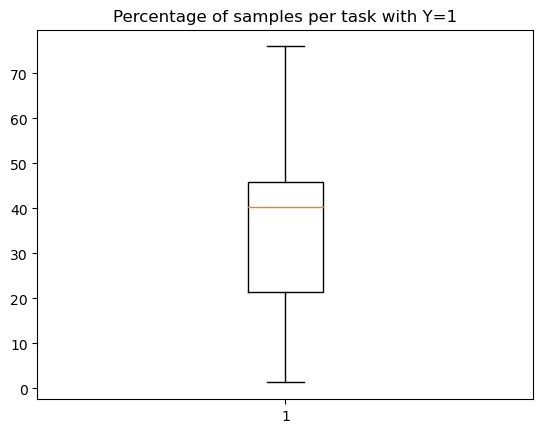

In [34]:
import matplotlib.pyplot as plt

plt.boxplot(perc_label_one)
plt.title("Percentage of samples per task with Y=1")

31.242424242424246
27.620293706368855
0.0
86.66666666666667


Text(0.5, 1.0, 'Percentage of samples per task with RT=1')

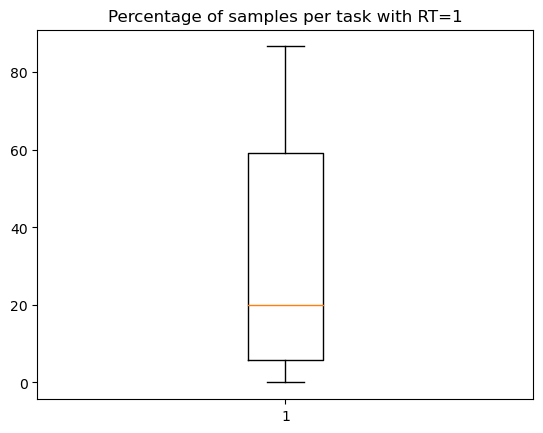

In [39]:
perc_rt = (dataset.groupby(['task']).sum()['X_radiation_therapy'] / 150).to_numpy() * 100

print(perc_rt.mean())
print(perc_rt.std())
print(perc_rt.min())
print(perc_rt.max())

plt.boxplot(perc_rt)
plt.title("Percentage of samples per task with RT=1")

Text(0.5, 0, '% samples per task with RT=1')

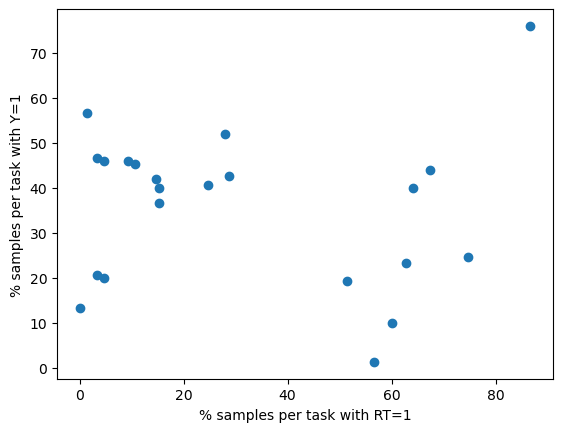

In [42]:
plt.scatter(perc_rt, perc_label_one)
plt.ylabel('% samples per task with Y=1')
plt.xlabel('% samples per task with RT=1')